In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.utils import shuffle
# pd.set_option('display.max_rows', None)

## Data Input and Suffle Data
- read data from kaggle notebook input folder

In [2]:
df = pd.read_json("../input/recipe/train.json")
df = shuffle(df, random_state =52)
df.set_index('id', inplace = True)
df_sub = pd.read_json("../input/recipe/test.json")
# df_sub.set_index('id', inplace = True)

## Data Preprocessing
1. Create a simple funtion: simplified_ingre to reduce each ingredients to only two last words, in order to eliminate the additional adj. in front of some ingredients.
2. For each data(row) combine every one of its ingredients to a single string, so that TfidfVectorizer can correctly do the trick to exract features.
3. Do One-Hot encoding for labels(y) so that its form can work with softmax.

In [3]:
def simplified_ingre(ingre):
    simp_ingre = []
    for i in ingre:
        ii = i.split(' ')
        if len(ii) >= 2:
            simp_ingre.append(ii[len(ii) - 2] + ' ' + ii[len(ii) - 1])
        else:
            simp_ingre.append(ii[0])
    return simp_ingre
    
df['ingredients'] = df['ingredients'].apply(simplified_ingre)
df_sub['ingredients'] = df_sub['ingredients'].apply(simplified_ingre)

In [4]:
df['ingredients'] = df['ingredients'].str.join(', ')
df_sub['ingredients'] = df_sub['ingredients'].str.join(', ')

In [5]:
X = df['ingredients']
X_sub = df_sub['ingredients']
y = pd.get_dummies(df['cuisine'])
# y = df['cuisine']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.30, random_state = 52)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()  
X_train = vectorizer.fit_transform(X_train).todense()
X_vali = vectorizer.transform(X_vali).todense()
X_sub = vectorizer.transform(X_sub).todense()

# X = vectorizer.fit_transform(X).todense()
# X_sub = vectorizer.transform(X_sub).todense()

In [8]:
cuisine = y.columns.tolist()
id_to_cuisine = {}
for i in range(len(cuisine)):
    id_to_cuisine[i] = cuisine[i]

## Model Construction
- Network layer satructure: input--Dense--Dropout--Dense--Dropout--softmax
    - After reading some examples on the internet and trying out differernt structures i choose this simple Sequential model, since more layers didn't seem to improve and only one layer well perform poorly, and the reason for dropout layer is that to have some regularization to avoid overfitting.
- Optimizer: stochastic gradient descent
    - My choice is SGD because I want the NN to learn quicker by updating parameters more frequency.
- Epoch and Batch size: 100/256
    - First I choose 50 epoch, after some experiments I observe that increase epoch will perform better but more than 100 epochs didn't seem to improve much, and batch size fewer than 256 seems to learn too fast and quickly converge then stuck, with 256 I feel like the speed is appropriate, more than 256 feel to slow for me.  

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD


model = Sequential()
model.add(Dense(2000, activation='relu', input_dim=X_train.shape[1]))
# model.add(Dense(2000, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))
# model.add(Dense(200, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
    
model.fit(X_train, y_train, epochs=100, batch_size=256, verbose=1, validation_data=(X_vali, y_vali))
# model.fit(X, y, epochs=100, batch_size=256, verbose=1)

Epoch 1/100
82/82 [==============================] - 1s 9ms/step - loss: 2.7464 - accuracy: 0.1958 - val_loss: 2.5889 - val_accuracy: 0.2016
Epoch 2/100
82/82 [==============================] - 0s 5ms/step - loss: 2.5499 - accuracy: 0.2490 - val_loss: 2.5040 - val_accuracy: 0.2865
Epoch 3/100
82/82 [==============================] - 0s 6ms/step - loss: 2.4445 - accuracy: 0.3027 - val_loss: 2.3578 - val_accuracy: 0.3330
Epoch 4/100
82/82 [==============================] - 0s 5ms/step - loss: 2.2561 - accuracy: 0.3757 - val_loss: 2.1187 - val_accuracy: 0.4202
Epoch 5/100
82/82 [==============================] - 0s 6ms/step - loss: 2.0238 - accuracy: 0.4637 - val_loss: 1.8892 - val_accuracy: 0.5074
Epoch 6/100
82/82 [==============================] - 0s 5ms/step - loss: 1.8383 - accuracy: 0.5030 - val_loss: 1.7232 - val_accuracy: 0.5247
Epoch 7/100
82/82 [==============================] - 0s 5ms/step - loss: 1.6991 - accuracy: 0.5258 - val_loss: 1.5974 - val_accuracy: 0.5382
Epoch 8/100
8

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes )
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
y_pred = model.predict_classes(X_vali)
ans = []
for p in y_pred:
    ans.append(id_to_cuisine[p])
y_pred = ans

ans = []
c_all = y_vali.columns.tolist()
for row in range(y_vali.shape[0]):
    for i in range(len(c_all)):
        if y_vali.iloc[row].tolist()[i] == 1:
            ans.append(id_to_cuisine[i])
y_true = ans

## Results

              precision    recall  f1-score   support

   brazilian       0.68      0.44      0.53       100
     british       0.49      0.45      0.47       179
cajun_creole       0.80      0.70      0.75       375
     chinese       0.79      0.86      0.82       561
    filipino       0.68      0.55      0.61       159
      french       0.62      0.60      0.61       599
       greek       0.74      0.74      0.74       248
      indian       0.86      0.90      0.88       723
       irish       0.67      0.41      0.51       167
     italian       0.82      0.89      0.86      1800
    jamaican       0.80      0.69      0.74       121
    japanese       0.82      0.75      0.78       330
      korean       0.86      0.74      0.79       183
     mexican       0.88      0.94      0.91      1359
    moroccan       0.79      0.78      0.78       174
     russian       0.72      0.38      0.50       120
 southern_us       0.73      0.82      0.77       979
     spanish       0.60    

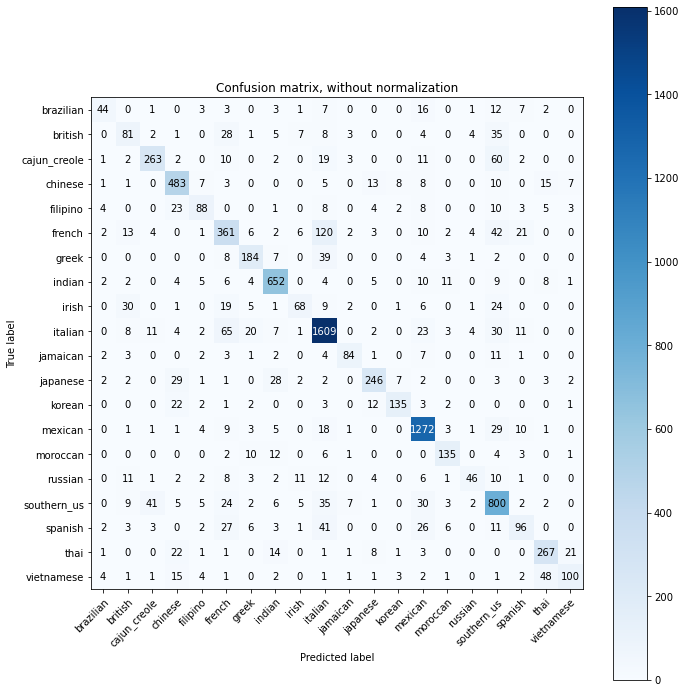

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
plot_confusion_matrix(y_true, y_pred, classes=np.array(c_all), cmap=plt.cm.Blues)
plt.show()

## Comparison & Conclusion
- This is my first time trying out deep laerning stuff, its cool but i feel like there are still a lot to learn, especially regarding how to train and adjust the network, overall itis very exciting to train my first ANN, I wish I can apply and really understand how to use the knowledge learnd from class to tune the model.
- Compare to SVM, I feel like there're still so much we can do on ANN to adjust the model and find better strucure, instead of just keep doing feature engineering and data preprocessing.
- For the final results, SVM and ANN have similar accuracy, however, after training with all the data, ANN performed better than SVM on kaggle public leaderboard, so I choose ANN to do the prediction for kaggle competition.

## Create output csv for kaggle submission

In [13]:
pre = model.predict_classes(X_sub)
ans = []
for p in pre:
    ans.append(id_to_cuisine[p])

y_sub = pd.DataFrame()
y_sub['Id'] = df_sub['id']
y_sub['Category'] = ans
y_sub.to_csv('./output.csv', index=False)